# 06 - Apply Doc2Vec to the Governance Data Set
This notebook explores the governance data set using Doc2Vec.

This code is largely based on [Document-Clustering-Doc2vec](https://github.com/aniketbote/Document-Clustering-Doc2vec/blob/master/Clustering/Clustering_code_Doc2Vec/clustering_Documents_Doc2Vec.py) by [Aniket Bote](https://github.com/aniketbote).

---
## Dependencies and Imports
This section deals with fulfilling depenencies and installing the right packages for use in the code below.

Something to keep in mind is that a lot of sample code out there uses Gensum version 3, where we use the current-as-of-this-writing Gensim version 4. The API has changed quite a bit between versions 3 and 4 and sample code may need to be refactored to use the new API before it works. Most changes are in the naming and will cause run-time errors, so finding problems is easy.

In [1]:
!pip install gensim fastparquet

In [2]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import __version__ as gensim__version__
print(f"gensim=={gensim__version__}")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")


python==3.11.3
pandas==2.0.2
gensim==4.3.1
scikit-learn==1.2.2
matplotlib==3.7.1


---
## Load DV Data Set
This loads the DV data set. We first load as a Panda, because we have the code. Then we make the resultant `corpus` into the list of tagged documents that Gensim is designed to work with.

We also load the municipalities evaluation set. We will use that after clustering with the intention to be able to relate clusters to municipalities.

Finally, we load the document properties. These will help identify document classification issues by looking at the titles.


In [3]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [4]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus.head()


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...


In [5]:
def make_into_tagged_documents(series):
    return [TaggedDocument(doc.split(' '), [i]) for i, doc in series.items()]

In [6]:
all_content = make_into_tagged_documents(corpus[DOCUMENT_BODY])
for i in range(5):
    print(f"{all_content[i].tags[0]}: {all_content[i].words[:5]}".replace("]", " ..."))

GM0003DV02: ['duurzaamheidsbeleid', 'Appingedam', 'duurzaamheidsbeleid', 'Appingedam', 'Inhoud' ...
GM0005DV01: ['colofon', 'gemeente', 'bedum', 'bezoekadres', 'Schoolstraat' ...
GM0007DV01: ['Milieubeleidsplan', 'vaststellen', 'gemeenteraad', 'bellingweden', 'maart' ...
GM0009DV01: ['inhoud', 'duurzaamheidsvisie', 'februari', 'inhoud', 'inhoud' ...
GM0034DV01: ['verseonnr', 'dagmail', 'december', 'raad', 'gemeente' ...


In [7]:
municipalities = pd.read_parquet("../data/CBS/Evaluation_data.parquet")
municipalities


,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
index,,,,,,,,,,,,,,,,,,,
0,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
2,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
3,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
4,GM0010,Delfzijl,Groningen,Klein,Arm,weinig stedelijk,Lokaal,Veel,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,GM1940,De Fryske Marren,Fryslân,Middelgroot,Modaal,weinig stedelijk,None,Gemiddeld,Veel,Veel,Gemiddeld,Gemiddeld,Gemiddeld,Middel,Laag,Middel,Middel,iets minder,meer
386,GM1942,Gooise Meren,Noord-Holland,Middelgroot,Rijk,sterk stedelijk,VVD,Geen,Beperkt,Geen,Beperkt,Geen,Beperkt,Hoog,Middel,Middel,Middel,veel lager,iets minder
387,GM1945,Berg en Dal,Gelderland,Middelgroot,Modaal,weinig stedelijk,Lokaal,Geen,Beperkt,Geen,Gemiddeld,Geen,Gemiddeld,Middel,Middel,Middel,Middel,iets minder,iets minder


In [8]:
documents = pd.read_csv("../data/Governance/Duurzaamheidsvisies.csv", index_col='DocID')
documents['Jaar'] = documents['Jaar'].astype(STRING).str.slice(0, 4)

documents


,Titel,Jaar
DocID,,
GM0003DV01,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,<NA>
GM0003DV02,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,Milieubeleidsplan 2009-2012,2009
GM0007DV01,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,Duurzaamheidsvisie 2016-2018,2016
...,...,...
GM1945DV01,Duurzaamheidsprogramma - Gemeente Berg en Dal,2013
GM1955DV01,Milieuprogramma 2014,2014
GM1955DV02,Zonne-energie in het buitengebied,<NA>


Spoiler alert, one of the results of outlier detection on our clustering revealed that some documents were misclassified. The documents below are tagged as duurzaamheidvisie, but are really budget plans.

In [9]:
documents[documents['Titel'].str.contains("egrot")]

,Titel,Jaar
DocID,,
GM0331DV01,Programmabegroting 2016,2015
GM0852DV01,Programmabegroting 2016,2016
GM0981DV01,Programma begroting 2016,2015


---
## Train the Doc2Vec Model
With the data cleanly loaded, we can train the model. Since we are very much exploring and since training is relatively fast, we don't save the model. We simply retrain it every time.

In [10]:
d2v_model = Doc2Vec(all_content, vector_size=300, min_count=5, dm=0, alpha=0.0025, min_alpha=0.0001)
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=50, start_alpha=0.002, end_alpha=-0.016)


**XXX** Are we not overfitting if we have more vectors than documents? --> This is based on words, so the input dimensiion is not 250, but the combination of all 5-grams in all document.

In [11]:
d2v_model.dv.vectors.shape

(248, 300)

---
## Elbow and Cluster with K-Means
We use the learned vectors to cluster the DV data set again using K-Means clustering. First we run K-Means clustering for different cluster sizes to make the elbow plot. Then we run K-Means to find the optimal number of clusters that we chose based on the elbow plot. We chose 5.

**XXX** How do the elbow plots relate between our previous K-Means?

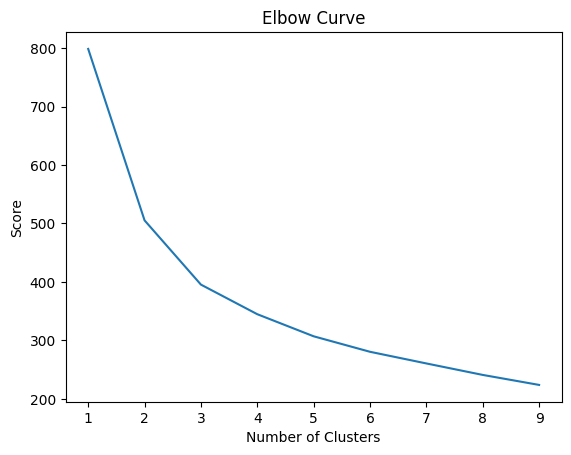

In [12]:
nc = range(1,10)
kmeans = []
score = []
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 500) for i in nc]               
score =  [kmeans[i].fit(d2v_model.dv.vectors).inertia_ for i in range(len(kmeans))]

# Plot the elbow
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [13]:
K_value = 5
kmeans_model = KMeans(n_clusters=K_value, n_init='auto') 
X = kmeans_model.fit(d2v_model.dv.vectors)
clusters = kmeans_model.predict(d2v_model.dv.vectors)
labels = kmeans_model.labels_.tolist()


---
## PCA Analysis and Plotting
We use Principal Component Analysis (PCA) to flatten the 300-dimension document vectors onto a 2D shape for plotting. The banding in the graph below is an artefact of PCA, causing the clusters to appear more disjunct than they really are.

In [14]:
l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)


In [15]:
datapoint.shape

(248, 2)

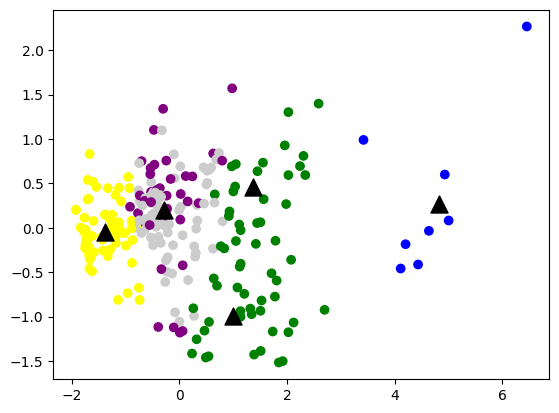

In [16]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#cccccc"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')

plt.show()


---
## Link to Municipality Data
This section three-way merges the clusters we found with the municipality data and document details for evaluation. Municipalities are indexed by their GM-code. Documents by their base file name.

In [21]:
CLUSTER='cluster'
MUNICIPALITY_ID='GM_Code'

kmeans_clusters = pd.DataFrame(index=corpus.index)
kmeans_clusters['DocID'] = corpus.index
kmeans_clusters[CLUSTER] = labels
kmeans_clusters[MUNICIPALITY_ID] = corpus.index.str.slice(0, 6)

kmeans_clusters.head()

,DocID,cluster,GM_Code
GM0003DV02,GM0003DV02,4,GM0003
GM0005DV01,GM0005DV01,3,GM0005
GM0007DV01,GM0007DV01,1,GM0007
GM0009DV01,GM0009DV01,4,GM0009
GM0034DV01,GM0034DV01,4,GM0034


In [22]:
kmeans_clusters_with_municipalities = kmeans_clusters.merge(municipalities, how="left", on=MUNICIPALITY_ID).set_index('DocID')

# the merge adds suffixes to ensure unique column names, so we strip those off
# again since we have no name clashes.
kmeans_clusters_with_municipalities.columns=kmeans_clusters_with_municipalities.columns.str.rstrip('_x') 
kmeans_clusters_with_municipalities.head()


,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
DocID,,,,,,,,,,,,,,,,,,,,
GM0003DV02,4,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
GM0005DV01,3,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
GM0007DV01,1,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
GM0009DV01,4,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
GM0034DV01,4,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,Veel,Veel,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager


In [23]:
kmeans_clusters_with_everything = kmeans_clusters_with_municipalities.join(documents)
kmeans_clusters_with_everything.head()



,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,...,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat,Titel,Jaar
DocID,,,,,,,,,,,,,,,,,,,,,
GM0003DV02,4,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,...,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,3,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,...,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder,Milieubeleidsplan 2009-2012,2009
GM0007DV01,1,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,...,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,4,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,...,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,4,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,...,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager,Plan van aanpak duurzaamheidsagenda,2010


In [26]:
kmeans_clusters_with_everything.loc[kmeans_clusters[CLUSTER]==4, ['GM_Code', 'Gemeente', 'Titel', 'Jaar']]


,GM_Code,Gemeente,Titel,Jaar
DocID,,,,
GM0003DV02,GM0003,Appingedam,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0009DV01,GM0009,Ten Boer,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,GM0034,Almere,Plan van aanpak duurzaamheidsagenda,2010
GM0034DV02,GM0034,Almere,Afspraken Duurzaam Almere 2012-2014,2012
GM0056DV01,GM0056,Zuidhorn,duurzaamheids beleid op weg naar duurzame geme...,2015
...,...,...,...,...
GM1740DV02,GM1740,Neder-Betuwe,Duurzaamheidsvisie Neder-Betuwe 2016-2020 Part...,2015
GM1783DV01,GM1783,Westland,Duurzaamheidsagenda 2012-2020 - Gemeente Westland,2012
GM1883DV01,GM1883,Sittard-Geleen,duurzaamheidsnota sittard-geleen 2012-2016,2012
